# Premier League Match Winners Prediction

In [10]:
#requests is a popular Python library for making HTTP requests. 
#It provides a convenient and easy-to-use interface for sending HTTP requests and receiving responses from web services and websites.

import requests
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"
data = requests.get(standings_url)
from bs4 import BeautifulSoup
soup = BeautifulSoup(data.text)
standings_table = soup.select('table.stats_table')[0]
links = standings_table.find_all('a')
links = [l.get("href") for l in links]
links = [l for l in links if '/squads/' in l]
team_urls = [f"https://fbref.com{l}" for l in links]
data = requests.get(team_urls[0])
import pandas as pd
matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
soup = BeautifulSoup(data.text)
links = soup.find_all('a')
links = [l.get("href") for l in links]
links = [l for l in links if l and 'all_comps/shooting/' in l]
data = requests.get(f"https://fbref.com{links[0]}")
shooting = pd.read_html(data.text, match="Shooting")[0] #shooting data
shooting.head()

For Manchester City                                                     \
                 Date   Time              Comp                Round  Day   
0          2023-08-06  16:00  Community Shield  FA Community Shield  Sun   
1          2023-08-11  20:00    Premier League          Matchweek 1  Fri   
2          2023-08-16  22:00         Super Cup       UEFA Super Cup  Wed   
3          2023-08-19  20:00    Premier League          Matchweek 2  Sat   
4          2023-08-27  14:00    Premier League          Matchweek 3  Sun   

                                                ... Standard                \
     Venue Result     GF     GA       Opponent  ...     Dist   FK PK PKatt   
0  Neutral      D  1 (1)  1 (4)        Arsenal  ...      NaN  NaN  0     0   
1     Away      W      3      0        Burnley  ...     13.9  0.0  0     0   
2     Home      D  1 (5)  1 (4)     es Sevilla  ...      NaN  NaN  0     0   
3     Home      W      1      0  Newcastle Utd  ...     17.9  0.0  0     0   
4     Away      W      2      1  Sheffield Utd  ...     17.3  2.0  0     1   

  Expected                           Unnamed: 25_level_0  
        xG npxG npxG/Sh G-xG np:G-xG        Match Report  
0      NaN  NaN     NaN  NaN     NaN        Match Report  
1      1.9  1.9    0.12  1.1     1.1        Match Report  
2      NaN  NaN     NaN  NaN     NaN        Match Report  
3      1.0  1.0    0.07  0.0     0.0        Match Report  
4      3.5  2.8    0.10 -1.5    -0.8        Match Report  

[5 rows x 26 columns]

In [11]:
shooting.columns = shooting.columns.droplevel()
team_data = matches.merge(shooting[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]], on="Date")
team_data.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,Formation,Referee,Match Report,Notes,Sh,SoT,Dist,FK,PK,PKatt
0,2023-08-06,16:00,Community Shield,FA Community Shield,Sun,Neutral,D,1 (1),1 (4),Arsenal,...,4-2-3-1,Stuart Attwell,Match Report,Arsenal won on penalty kicks following normal ...,8,4,NaN,NaN,0,0
1,2023-08-11,20:00,Premier League,Matchweek 1,Fri,Away,W,3,0,Burnley,...,4-2-3-1,Craig Pawson,Match Report,NaN,17,8,13.9,0.0,0,0
2,2023-08-16,22:00,Super Cup,UEFA Super Cup,Wed,Home,D,1 (5),1 (4),es Sevilla,...,4-2-3-1,François Letexier,Match Report,NaN,23,7,NaN,NaN,0,0
3,2023-08-19,20:00,Premier League,Matchweek 2,Sat,Home,W,1,0,Newcastle Utd,...,4-2-3-1,Robert Jones,Match Report,NaN,14,4,17.9,0.0,0,0
4,2023-08-27,14:00,Premier League,Matchweek 3,Sun,Away,W,2,1,Sheffield Utd,...,4-2-3-1,Jarred Gillett,Match Report,NaN,29,9,17.3,2.0,0,1


In [13]:
years = list(range(2023, 2020, -1))
all_matches = []
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"
import time
for year in years:
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    standings_table = soup.select('table.stats_table')[0]

    links = [l.get("href") for l in standings_table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    previous_season = soup.select("a.prev")[0].get("href")
    standings_url = f"https://fbref.com{previous_season}"
    
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
        data = requests.get(team_url)
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        soup = BeautifulSoup(data.text)
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/shooting/' in l]
        data = requests.get(f"https://fbref.com{links[0]}")
        shooting = pd.read_html(data.text, match="Shooting")[0]
        shooting.columns = shooting.columns.droplevel()
        try:
            team_data = matches.merge(shooting[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]], on="Date")
        except ValueError:
            continue
        team_data = team_data[team_data["Comp"] == "Premier League"]
        
        team_data["Season"] = year
        team_data["Team"] = team_name
        all_matches.append(team_data)
        time.sleep(5)

In [15]:
match_df = pd.concat(all_matches)
match_df.columns = [c.lower() for c in match_df.columns]
match_df
match_df.to_csv("matches.csv")

In [16]:
len(all_matches)
match_df = pd.concat(all_matches)
match_df.columns = [c.lower() for c in match_df.columns]
match_df

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
1,2023-08-11,20:00,Premier League,Matchweek 1,Fri,Away,W,3,0,Burnley,...,Match Report,NaN,17.0,8.0,13.9,0.0,0.0,0.0,2023,Manchester City
3,2023-08-19,20:00,Premier League,Matchweek 2,Sat,Home,W,1,0,Newcastle Utd,...,Match Report,NaN,14.0,4.0,17.9,0.0,0.0,0.0,2023,Manchester City
4,2023-08-27,14:00,Premier League,Matchweek 3,Sun,Away,W,2,1,Sheffield Utd,...,Match Report,NaN,29.0,9.0,17.3,2.0,0.0,1.0,2023,Manchester City
5,2023-09-02,15:00,Premier League,Matchweek 4,Sat,Home,W,5,1,Fulham,...,Match Report,NaN,6.0,4.0,14.8,0.0,1.0,1.0,2023,Manchester City
0,2023-08-13,14:00,Premier League,Matchweek 1,Sun,Away,D,2,2,Brentford,...,Match Report,NaN,18.0,6.0,19.6,0.0,0.0,0.0,2023,Tottenham Hotspur
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,2022-04-30,15:00,Premier League,Matchweek 35,Sat,Away,L,0,2,Aston Villa,...,Match Report,NaN,9.0,3.0,21.6,0.0,0.0,0.0,2021,Norwich City
39,2022-05-08,14:00,Premier League,Matchweek 36,Sun,Home,L,0,4,West Ham,...,Match Report,NaN,8.0,2.0,22.2,1.0,0.0,0.0,2021,Norwich City
40,2022-05-11,19:45,Premier League,Matchweek 21,Wed,Away,L,0,3,Leicester City,...,Match Report,NaN,9.0,5.0,17.0,0.0,0.0,0.0,2021,Norwich City
41,2022-05-15,14:00,Premier League,Matchweek 37,Sun,Away,D,1,1,Wolves,...,Match Report,NaN,11.0,2.0,14.4,0.0,0.0,0.0,2021,Norwich City


# Exploratory Data Analysis(EDA):

## 1. Data Loading

In [190]:
import pandas as pd

# Specify the path of the CSV file
csv_file_path = r"C:\Users\13018\Downloads\matches.xls"  # Replace with the actual path to your CSV file

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path, index_col=0)


In [191]:
df

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
1,2023-08-11,20:00,Premier League,Matchweek 1,Fri,Away,W,3.0,0.0,Burnley,...,Match Report,NaN,17.0,8.0,13.9,0.0,0.0,0.0,2023,Manchester City
3,2023-08-19,20:00,Premier League,Matchweek 2,Sat,Home,W,1.0,0.0,Newcastle Utd,...,Match Report,NaN,14.0,4.0,17.9,0.0,0.0,0.0,2023,Manchester City
4,2023-08-27,14:00,Premier League,Matchweek 3,Sun,Away,W,2.0,1.0,Sheffield Utd,...,Match Report,NaN,29.0,9.0,17.3,2.0,0.0,1.0,2023,Manchester City
5,2023-09-02,15:00,Premier League,Matchweek 4,Sat,Home,W,5.0,1.0,Fulham,...,Match Report,NaN,6.0,4.0,14.8,0.0,1.0,1.0,2023,Manchester City
0,2023-08-13,14:00,Premier League,Matchweek 1,Sun,Away,D,2.0,2.0,Brentford,...,Match Report,NaN,18.0,6.0,19.6,0.0,0.0,0.0,2023,Tottenham Hotspur
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,2022-04-30,15:00,Premier League,Matchweek 35,Sat,Away,L,0.0,2.0,Aston Villa,...,Match Report,NaN,9.0,3.0,21.6,0.0,0.0,0.0,2021,Norwich City
39,2022-05-08,14:00,Premier League,Matchweek 36,Sun,Home,L,0.0,4.0,West Ham,...,Match Report,NaN,8.0,2.0,22.2,1.0,0.0,0.0,2021,Norwich City
40,2022-05-11,19:45,Premier League,Matchweek 21,Wed,Away,L,0.0,3.0,Leicester City,...,Match Report,NaN,9.0,5.0,17.0,0.0,0.0,0.0,2021,Norwich City
41,2022-05-15,14:00,Premier League,Matchweek 37,Sun,Away,D,1.0,1.0,Wolves,...,Match Report,NaN,11.0,2.0,14.4,0.0,0.0,0.0,2021,Norwich City


## 2. Basic attributes

In [192]:
df.shape

(1598, 27)

In [193]:
#value counts
df["round"].value_counts()

Matchweek 1     60
Matchweek 4     60
Matchweek 3     60
Matchweek 2     58
Matchweek 32    40
Matchweek 37    40
Matchweek 36    40
Matchweek 35    40
Matchweek 28    40
Matchweek 34    40
Matchweek 23    40
Matchweek 31    40
Matchweek 30    40
Matchweek 29    40
Matchweek 27    40
Matchweek 26    40
Matchweek 25    40
Matchweek 24    40
Matchweek 12    40
Matchweek 33    40
Matchweek 21    40
Matchweek 22    40
Matchweek 13    40
Matchweek 5     40
Matchweek 6     40
Matchweek 8     40
Matchweek 9     40
Matchweek 10    40
Matchweek 11    40
Matchweek 14    40
Matchweek 7     40
Matchweek 15    40
Matchweek 16    40
Matchweek 17    40
Matchweek 18    40
Matchweek 19    40
Matchweek 20    40
Matchweek 38    40
Name: round, dtype: int64

In [194]:
38*20*2 + 4*20

1600

In the English Premier League, the three teams with the lowest number of points at the end of the season are relegated to the EFL Championship, which is the second tier of English football. Relegation means that these teams will no longer compete in the Premier League in the following season.

Relegation: Initially, the team was relegated from the Premier League to a lower division, such as the EFL Championship.

Participation in Lower Division: While in the lower division, the team continued to compete in league matches in that division, as well as any cup competitions relevant to that division.

Promotion: After a successful season in the lower division, the team earned promotion back to the Premier League. Promotion often involves finishing high in the league standings or winning promotion playoff matches, depending on the league's rules.

Return to the Premier League: Upon promotion, the team returned to the Premier League, where they would play the standard 38-match schedule for Premier League teams.
    

In [195]:
# data types
df.dtypes

date             object
time             object
comp             object
round            object
day              object
venue            object
result           object
gf              float64
ga              float64
opponent         object
xg              float64
xga             float64
poss            float64
attendance      float64
captain          object
formation        object
referee          object
match report     object
notes           float64
sh              float64
sot             float64
dist            float64
fk              float64
pk              float64
pkatt           float64
season            int64
team             object
dtype: object

In [198]:
df["date"]=pd.to_datetime(df["date"])
#converting the 'date' column to a datetime data type, allowing you to work with date-related functions and perform time-based analysis on the data

In [199]:
df.dtypes

date            datetime64[ns]
time                    object
comp                    object
round                   object
day                     object
venue                   object
result                  object
gf                     float64
ga                     float64
opponent                object
xg                     float64
xga                    float64
poss                   float64
attendance             float64
captain                 object
formation               object
referee                 object
match report            object
notes                  float64
sh                     float64
sot                    float64
dist                   float64
fk                     float64
pk                     float64
pkatt                  float64
season                   int64
team                    object
dtype: object

In [200]:
# Basic summary statistics
print(df.describe())

                gf           ga           xg          xga         poss  \
count  1598.000000  1598.000000  1598.000000  1598.000000  1598.000000   
mean      1.428035     1.428035     1.394743     1.394743    50.000626   
std       1.307754     1.307754     0.825159     0.825159    12.596702   
min       0.000000     0.000000     0.000000     0.000000    18.000000   
25%       0.000000     0.000000     0.800000     0.800000    40.000000   
50%       1.000000     1.000000     1.300000     1.300000    50.000000   
75%       2.000000     2.000000     1.900000     1.900000    60.000000   
max       9.000000     9.000000     5.900000     5.900000    82.000000   

         attendance  notes           sh          sot         dist  \
count   1594.000000    0.0  1598.000000  1598.000000  1598.000000   
mean   39767.542033    NaN    12.677722     4.192115    17.209637   
std    15998.913896    NaN     5.491670     2.444631     2.908745   
min     9972.000000    NaN     1.000000     0.000000     

## 3. Data Cleaning

In [201]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1598 entries, 1 to 42
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1598 non-null   datetime64[ns]
 1   time          1598 non-null   object        
 2   comp          1598 non-null   object        
 3   round         1598 non-null   object        
 4   day           1598 non-null   object        
 5   venue         1598 non-null   object        
 6   result        1598 non-null   object        
 7   gf            1598 non-null   float64       
 8   ga            1598 non-null   float64       
 9   opponent      1598 non-null   object        
 10  xg            1598 non-null   float64       
 11  xga           1598 non-null   float64       
 12  poss          1598 non-null   float64       
 13  attendance    1594 non-null   float64       
 14  captain       1598 non-null   object        
 15  formation     1598 non-null   object    

In [151]:
# Verify that missing values have been removed
print(df.isnull().sum())

date               0
time               0
comp               0
round              0
day                0
venue              0
result             0
gf                 0
ga                 0
opponent           0
xg                 0
xga                0
poss               0
attendance         4
captain            0
formation          0
referee            0
match report       0
notes           1598
sh                 0
sot                0
dist               0
fk                 0
pk                 0
pkatt              0
season             0
team               0
dtype: int64


 Found that notes coloumn has been empty and of no use so dropping it would be the best approach and 4 missing attendances will be filled with the average attendance value


In [203]:
# Calculate the average attendance
average_attendance = df['attendance'].mean()

# Fill missing 'attendance' values with the average
df['attendance'].fillna(average_attendance, inplace=True)

In [204]:
# Delete the 'notes' column
df.drop(columns=['notes'], inplace=True)

In [205]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1598 entries, 1 to 42
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1598 non-null   datetime64[ns]
 1   time          1598 non-null   object        
 2   comp          1598 non-null   object        
 3   round         1598 non-null   object        
 4   day           1598 non-null   object        
 5   venue         1598 non-null   object        
 6   result        1598 non-null   object        
 7   gf            1598 non-null   float64       
 8   ga            1598 non-null   float64       
 9   opponent      1598 non-null   object        
 10  xg            1598 non-null   float64       
 11  xga           1598 non-null   float64       
 12  poss          1598 non-null   float64       
 13  attendance    1598 non-null   float64       
 14  captain       1598 non-null   object        
 15  formation     1598 non-null   object    

## 4. Data Visualisation

### Bar chart for Number of Games Played by Teams in Different Seasons

In [155]:
import pandas as pd
import plotly.express as px

# Calculate the number of games played for each team in each season
games_played_by_season = df.groupby(['team', 'season']).size().reset_index(name='num_games_played')

# Create a bar chart for games played by teams in different seasons
fig = px.bar(
    games_played_by_season,
    x='team',
    y='num_games_played',
    color='season',
    title='Number of Games Played by Teams in Different Seasons',
    labels={'team': 'Team', 'num_games_played': 'Number of Games Played', 'season': 'Season'},
    category_orders={'team': sorted(games_played_by_season['team'].unique())},  # Sort teams alphabetically
)

# Customize the layout to rotate x-axis labels
fig.update_xaxes(
    title_text='Teams',  
    tickangle=45,    
)

fig.update_yaxes(title_text='Number of Games Played')

fig.show()


 visualising the number of seasons and number of games played by each team 

### Stacked Bar chart for Goals Scored at Home vs. Goals Scored Away by Team (Stacked)

In [156]:
import pandas as pd
import plotly.express as px

# Filter data for goals scored at home and goals scored away
home_goals_scored = df[df['venue'] == 'Home']
away_goals_scored = df[df['venue'] == 'Away']

# Group data by team and sum goals scored at home and away
home_goals_scored_grouped = home_goals_scored.groupby('team')['gf'].sum().reset_index()
away_goals_scored_grouped = away_goals_scored.groupby('team')['gf'].sum().reset_index()

# Merge home and away goals scored data
merged_goals_scored = home_goals_scored_grouped.merge(away_goals_scored_grouped, on='team', suffixes=('_home', '_away'))

# Calculate the number of games played for each team
num_games_played = df.groupby('team').size().reset_index(name='num_games_played')

# Merge the number of games played with the goals scored data
merged_goals_scored = merged_goals_scored.merge(num_games_played, on='team')

fig = px.bar(
    merged_goals_scored,
    x='team',
    y=['gf_home', 'gf_away'],
    title='Goals Scored at Home vs. Goals Scored Away by Team (Stacked)',
    labels={'team': 'Team', 'value': 'Goals Scored'},
    category_orders={'team': sorted(merged_goals_scored['team'].unique())},  # Sort teams alphabetically
    barmode='relative',  # Create a stacked bar chart
    color_discrete_sequence=['red', 'lightblue'],
)

# Customize the layout to rotate x-axis labels
fig.update_xaxes(
    title_text='Teams', 
    tickangle=45,     
)

fig.update_yaxes(title_text='Goals Scored')

# Adding text annotations at the top of each bar for the number of games played
for idx, row in merged_goals_scored.iterrows():
    fig.add_annotation(
        x=row['team'],
        y=row['gf_home'] + row['gf_away'],
        text=row['num_games_played'],
        showarrow=False,
        font=dict(size=10),
    )

fig.show()


### Stacked Bar chart for Goals Conceded at Home vs. Goals Conceded Away by Team (Stacked)

In [157]:
import pandas as pd
import plotly.express as px

# Filter data for goals conceded at home and  conceded away
home_goals_conceded = df[df['venue'] == 'Home']
away_goals_conceded = df[df['venue'] == 'Away']

# Group data by team and sum goals conceded at home and away
home_goals_conceded_grouped = home_goals_conceded.groupby('team')['ga'].sum().reset_index()
away_goals_conceded_grouped = away_goals_conceded.groupby('team')['ga'].sum().reset_index()

# Merge home and away goals conceded data
merged_goals_conceded = home_goals_conceded_grouped.merge(away_goals_conceded_grouped, on='team', suffixes=('_home', '_away'))

# Calculate the number of games played for each team
num_games_played = df.groupby('team').size().reset_index(name='num_games_played')

# Merge the number of games played with the goals conceded data
merged_goals_conceded = merged_goals_conceded.merge(num_games_played, on='team')


fig = px.bar(
    merged_goals_conceded,
    x='team',
    y=['ga_home', 'ga_away'],
    title='Goals Conceded at Home vs. Goals Conceded Away by Team (Stacked)',
    labels={'team': 'Team', 'value': 'Goals Conceded'},
    category_orders={'team': sorted(merged_goals_conceded['team'].unique())},  # Sort teams alphabetically
    barmode='relative',  # Create a stacked bar chart
    color_discrete_sequence=['green', 'yellow'],
)

# Customize the layout to rotate x-axis labels
fig.update_xaxes(
    title_text='Teams',    
    tickangle=45,     # Rotate x-axis labels by 45 degrees
)

fig.update_yaxes(title_text='Goals Conceded')

# Adding text annotations at the top of each bar for the number of games played
for idx, row in merged_goals_conceded.iterrows():
    fig.add_annotation(
        x=row['team'],
        y=row['ga_home'] + row['ga_away'],
        text=row['num_games_played'],
        showarrow=False,
        font=dict(size=10),
    )

fig.show()


### Horizantal Bar chart for Games Won, Lost, and Drawn by Teams

In [207]:
# Calculate the number of games won and games lost
df['games_won'] = df['result'].apply(lambda x: 1 if x == 'W' else 0)
df['games_lost'] = df['result'].apply(lambda x: 1 if x == 'L' else 0)
df['games_drawn'] = df['result'].apply(lambda x: 1 if x == 'D' else 0)

# Grouped bar chart for each team's games won and games lost
fig = px.bar(
    df,
    x=['games_won', 'games_lost', 'games_drawn'],
    y='team',
    orientation='h',  # Horizontal orientation
    title='Games Won and Games Lost by Teams',
    labels={'team': 'Team', 'value': 'Number of Games'},
    color_discrete_map={'games_won': 'red', 'games_lost': 'green','games_drawn':'lightblue'},  # Custom colors
)

# Customize the layout
fig.update_xaxes(title_text='Number of Games')
fig.update_yaxes(title_text='')

fig.show()


### Box plot for Possession Statistics for Winning and Losing Teams

In [159]:
import plotly.express as px

# Filter data for matches won
matches_won = df[df['result'] == 'W']

# Filter data for matches lost
matches_lost = df[df['result'] == 'L']

# Create a box plot to compare possession statistics for winning and losing teams
fig = px.box(
    pd.concat([matches_won, matches_lost]),
    x='result',
    y='poss',
    color='result',
    title='Possession Statistics for Winning and Losing Teams',
    labels={'result': 'Match Outcome', 'poss': 'Possession (%)'},
)

fig.update_traces(marker=dict(size=5))  # Adjust marker size if needed

fig.show()



### Scatter plot for expected goals vs actual goals 

In [208]:
import plotly.express as px

# Create a scatter plot for xG vs. GF
fig = px.scatter(df, x='xg', y='gf',color='team', size='gf', title='expected goals vs actual goals')

# Show the plot
fig.show()


### Scatter plot for Shot on goal vs actual goals scored

In [161]:
import plotly.express as px

# Create a scatter plot for SOT vs. GF
fig = px.scatter(df, x='sot', y='gf', color='team', size="sot", title='Shots on Target (SOT) vs. Goals Scored (GF)')

# Show the plot
fig.show()


### Pie Chart for total number of wins by each Team

In [162]:
import plotly.express as px

# Filter the DataFrame to count wins for each team
team_wins = df[df['result'] == 'W'].groupby('team').size().reset_index(name='wins')

# Create the pie chart
fig = px.pie(
    team_wins,
    names='team',  # Use 'team' as the names of the pie chart slices
    values='wins',  # Count of wins as the values
    title='Wins by Team'
)

# Customize the layout to display team names as labels
fig.update_traces(textposition='inside', textinfo='percent+label')

# Show the pie chart
fig.show()


## 4. Correlation Analysis:

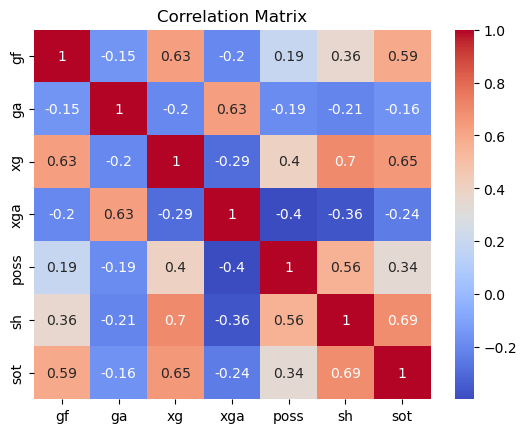

In [178]:
correlation_matrix = df[['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


### we conducted a comprehensive correlation analysis to explore the relationships between various performance metrics. Specifically, we calculated and visualized the correlation matrix among key performance metrics, including 'goals scored' (gf), 'goals conceded' (ga), 'expected goals' (xg), and other relevant factors.

## 5. Outlier Detection:

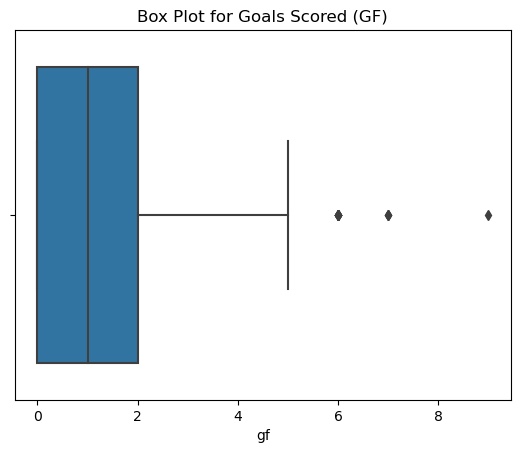

In [179]:
sns.boxplot(x=df['gf'])
plt.title('Box Plot for Goals Scored (GF)')
plt.show()


### Using box plots, we located and displayed potential outliers in the 'goals scored' variable (gf). This process provides a preliminary evaluation of the data quality and enables us to choose the best method for handling outliers, which can have an impact on the precision and robustness of later analyses and models.

## 6. Target variables: opposition, Venue, goals scored home, goals scored away.